# Intro to HPC: Solar Cell project

Project: Solar Power for Affordable Housing through Computational Design of Low-Cost/High-Efficiency Solar Cells.
Author: AlvaroVM [https://alvarovm.github.io](http://alvarovm.github.io)

Version: 0.0.2

## Part 5 Machine Learning - Supervised learning

In this notebook we will use Random Forest (RF) and Gaussian Process Regression (GPR) to predict the spectral peak that corresponds to the first excitation energy of the molecules in the DyeDB. 

We will use the finger prints and descriptor calculated in previous notebooks. The algorithms that we will use are implemente in the package Scikit-learn, which is a data science open source code.

### Exercises

* Run the RF and GPR over a sample of 1000 rows. Compare the two methods
* See the effect of increasing the numbers of rows, determine which of the two methods keeps improving when more data is added.
* Find patters among the clusters we found with t-SNE and HDBSCAN.
* Time two methods and estimate their scalability


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
import os
SRC_DIR='..'

sys.path.append(os.path.join(SRC_DIR, 'code'))
import utils

import pandas as pd
#https://github.com/jmcarpenter2/swifter
#import swifter
#2-TSNE-UMAP-map-cuda-Copy1

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs 
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint
from rdkit.DataStructs import ConvertToNumpyArray

from sklearn.manifold import TSNE

import hdbscan

import seaborn as sns

utils.plot_settings2()

results_path = os.path.join(SRC_DIR,'results')


def rmse(pred, target):
    """
    Input Args:
    pred: predictions numpy array
    target :True label numpy array
    return : rmse 
    """
    return np.sqrt(((pred - target) ** 2).mean())

../code/utils.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Load data

In [3]:
df = pd.read_pickle('my_dataframe.pkl').fillna(value = 0)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))
#df.head(2)

Column names: ['inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nostda', 'smiles', 'mol', 'morgan_fp_array', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'valid_smi', 'cannon_smiles', 'gap_mopac', 'gap_zindo', 'gap_dft']
Table Shape: (5660, 49)


### Clean data

In [4]:
#df=df[df['lambda_tddft (nm)']>0]
df=df[df['lambda_sTDA (nm)']>0]
df = df.sample(n=2500, replace=True, random_state=1)
df = df.reset_index()
#df=df[df['cluster']>-1]
print('Table Shape: {}'.format(df.shape))

Table Shape: (2500, 50)


#### Select input data

In [6]:
X = np.vstack(df['morgan_fp_array'])
target='lambda_sTDA (nm)'
y_true = df[target].values.reshape(-1,1).astype(np.float64)

#### Split data (testing and training)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y_true, test_size=0.25, random_state=1)

#### Standarize data

In [8]:
from sklearn.preprocessing import StandardScaler
y_preproc = StandardScaler()
y_train2 = y_preproc.fit_transform(y_train)

### Random Forest Regression

/tmp/ipykernel_2026178/2919903710.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train2)


Deviation std = 32.47417275828927
Max err = 180.822
mean errr = -0.5762083428571414
rmean = 32.479284357719386
R2 = 0.4607497058842899


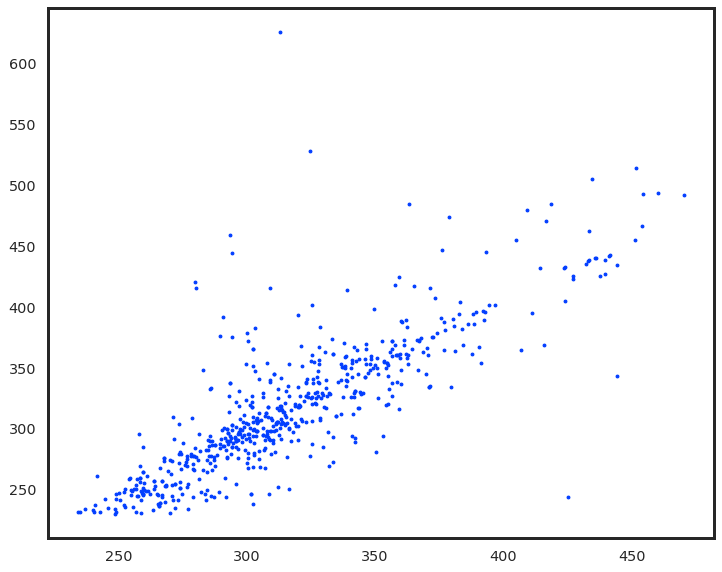

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

model = RandomForestRegressor()
model.fit(x_train, y_train2)
predictions = model.predict(x_test)
array_2d = predictions.reshape((len(predictions), 1))
y_pred = y_preproc.inverse_transform(array_2d)
plt.scatter(y_pred, y_test, marker='o',s=5)
diff= y_pred - y_test
stdd= np.std(diff)
print('Deviation std = {}'.format(stdd))
print('Max err = {}'.format(np.max(diff)))
print('mean errr = {}'.format(np.mean(diff)))
print('rmean = {}'.format(rmse(y_pred, y_test)))
print('R2 = {}'.format(r2_score(y_pred, y_test)))

### Gaussian Process Regression

Deviation std = 49.02190506734676
Max err = 92.5918612996974
mean errr = 1.7333164719015228
rmean = 49.05253879692388
R2 = -1.9080350214708317


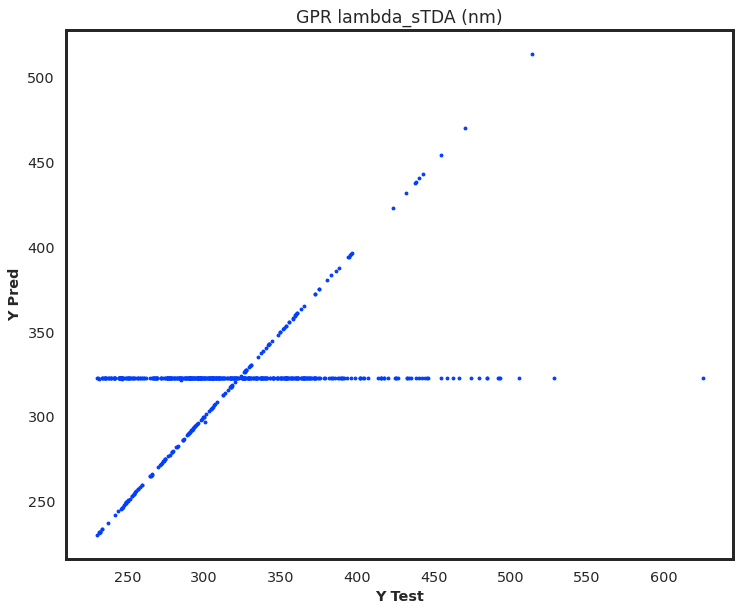

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score


# Create a Gaussian process regressor
gpr = GaussianProcessRegressor()
gpr.fit(x_train, y_train2)

predictions = gpr.predict(x_test)
# y_pred = predictions
array_2d = predictions.reshape((len(predictions), 1))
y_pred = y_preproc.inverse_transform(array_2d)


plt.scatter( y_test, y_pred, marker='o',s=5)
plt.xlabel('Y Test')
plt.ylabel('Y Pred')
plt.title(f"GPR {target}")
diff= y_pred - y_test
stdd= np.std(diff)
print('Deviation std = {}'.format(stdd))
print('Max err = {}'.format(np.max(diff)))
print('mean errr = {}'.format(np.mean(diff)))
print('rmean = {}'.format(rmse(y_pred, y_test)))
print('R2 = {}'.format(r2_score(y_pred, y_test)))